<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLeaning_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#循环神经网络
##序列模型
###时序数据
> * 实际中很多数据都是时序的,音乐,语言,文本,视频都是连续的.意思就是,在时间t观察到$x_t$,在一段时间T内,得到X个不独立的随机变量,他序列前后的样本是有关联的.
![sequence](http://pan.anderd.com/download/616a44c0511772003f5d263a)
马尔可夫假设，这就是说,假设当前数据只跟过去$\tau$个过去数据点相关
![马尔可夫](http://pan.anderd.com/download/616a45b4aff378003fdf7788)

> 潜变量模型
* 引入潜变量$h_t$来表示过去信息,$h_t=f(x_1,...,x_{t-1}),这样x_t=p(x_t|h_t)$
![潜变量模型](http://pan.anderd.com/download/616a477532f758004f18157c)


In [1]:
!pip install -U d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


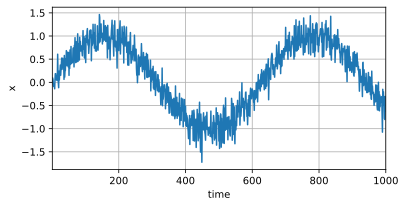

In [2]:
#马尔可夫假设训练一个mlp
#这里通过正弦函数和一些可加性噪声来生成序列数据，给定过去的数据，预测未来
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))

In [3]:
#应用马尔可夫假设，生成数据对，
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
#mlp模型
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)

def get_net():
  net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
  net.apply(init_weights)
  return net

loss = nn.MSELoss()

In [12]:
#模型训练
def train(net,train_iter,loss,epochs,lr):
  trainer = torch.optim.Adam(net.parameters(),lr)
  for epoch in range(epochs):
    for X,y in train_iter:
      trainer.zero_grad()
      l = loss(net(X),y)
      l.backward
      trainer.step()
    print(f'epoch {epoch+1}, 'f'loss:{d2l.evaluate_loss(net,train_iter,loss)}')

net = get_net()
train(net,train_iter,loss,5,0.075)

epoch 1, loss:0.17714800734661126
epoch 2, loss:0.1769518904191883
epoch 3, loss:0.1810822233949837
epoch 4, loss:0.17953811585903168
epoch 5, loss:0.1776876396646625


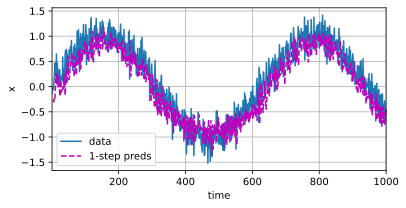

In [7]:
#单步预测，通过前4个数据预测后一个数据
onestep_preds = net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',legend=['data','1-step preds'],xlim=[1,1000],figsize=(6,3))

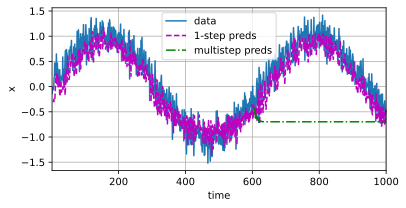

In [8]:
#多步预测
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
  multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1,-1)))

d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(),
     multistep_preds[n_train + tau:].detach().numpy()], 
     'time','x', legend=['data', '1-step preds', 'multistep preds'],
     xlim=[1, 1000], figsize=(6, 3))

> 可以看到单步预测的结果，虽然差，但比起更离谱的多步预测，还算可以，这表明mlp在预测以后一段长时间内的结果是不太行的。